
# AVPrivacy CARLA Demo (End-to-End)

This notebook is a **turn-key walkthrough** for the next engineer on the project.
It records RGB + Depth frames from CARLA, saves a short session to disk, and then
runs your anonymization pipeline (`AVPrivacyMasker`) on those frames. It ends by
showing a few sample outputs side-by-side.

**You need to have a CARLA server running first** (0.9.11 recommended for this repo).

### CARLA Simulator Download Instructions
##### Original source: https://github.com/arijitray1993/CARLA_tutorial/blob/main/playground.ipynb 

### Installation on Ubuntu

There are various ways to install CARLA:

### Easiest: Extract pre-computed binary file from their Github repo: 

Extract the appropriate tar.gz file from https://github.com/carla-simulator/carla/blob/master/Docs/download.md.

i.e. `wget -c https://github.com/carla-simulator/carla/releases/tag/0.9.11/ -O - | sudo tar -xz -C Carla911`

Personally, on Ubuntu 22.04, I have found version CARLA 0.9.11 to work best.

- Extract the package. 

### NEED PYTHON 3.7 with this Python API version
````
conda create -n python37-911 python=3.7
````

**Quick start (in a terminal, not in this notebook):**
```bash
# activate your env (example)
conda activate python37-911

# from your CARLA install path (adjust for your setup)
./force_nvidia_egl.sh ./CarlaUE4.sh -RenderOffscreen -quality-level=Epic -fps=20
```



## 1) Environment & Paths

Set your repo root and add the CARLA Python API to `sys.path`. Edit these if your
paths differ. By default this notebook assumes you cloned the repo under:

```
/home/summer2025/AVPrivacy/AVPrivacy-Simulation
```


In [1]:

# --- Edit these if your paths are different ---
REPO_ROOT = "/home/summer2025/AVPrivacy/AVPrivacy-Simulation"
# If your CARLA Python API is in a different place, update CARLA_PY_ROOT accordingly.
# Common example: "../carla_sim/PythonAPI"
CARLA_PY_ROOT = f"{REPO_ROOT}/carla_sim/PythonAPI"

import os, sys, glob
from pathlib import Path

sys.path.append(REPO_ROOT)
# Add CARLA Python API (egg) + util scripts to path
for egg in glob.glob(os.path.join(CARLA_PY_ROOT, "carla", "dist", "carla-*py3*.egg")):
    if egg not in sys.path:
        sys.path.append(egg)
utils_path = os.path.join(CARLA_PY_ROOT, "carla")
if utils_path not in sys.path:
    sys.path.append(utils_path)

print("Repo root:", REPO_ROOT)
print("CARLA PY root:", CARLA_PY_ROOT)
print("Eggs seen:", [p for p in sys.path if "carla-" in p and p.endswith(".egg")])


Repo root: /home/summer2025/AVPrivacy/AVPrivacy-Simulation
CARLA PY root: /home/summer2025/AVPrivacy/AVPrivacy-Simulation/carla_sim/PythonAPI
Eggs seen: ['/home/summer2025/AVPrivacy/AVPrivacy-Simulation/carla_sim/PythonAPI/carla/dist/carla-0.9.11-py3.7-linux-x86_64.egg']



## 2) Imports
If you get an import error for `carla`, double-check the path cell above and that
the CARLA server is the 0.9.11 build used by the project.


In [2]:

import time, random, queue
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

import carla  # must succeed
from carla import libcarla

# Your anonymizer
from av_privacy_masker import AVPrivacyMasker


/home/summer2025/miniconda3/envs/python37-911/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## 3) Connect to CARLA and configure the world

We use synchronous mode and a fixed delta so RGB/Depth stay aligned.


In [3]:

client = carla.Client("localhost", 2000)
client.set_timeout(10.0)

world = client.load_world("Town02")
settings = world.get_settings()
settings.synchronous_mode = True
settings.fixed_delta_seconds = 0.05  # physics step; keep <= 0.1
world.apply_settings(settings)

# Nice daytime preset
world.set_weather(carla.WeatherParameters.CloudyNoon)

print("Connected to:", world.get_map().name)


Connected to: Town02



## 4) Spawn an ego vehicle and attach RGB + Depth cameras

We use a fixed transform that is known to work in Town02, and a front-bumper camera.


In [4]:
actor_list = []

blueprint_library = world.get_blueprint_library()
veh_bp = blueprint_library.find('vehicle.audi.etron') or random.choice(blueprint_library.filter('vehicle.*'))

transform = carla.Transform(
    carla.Location(x=165.090042, y=187.119949, z=0.500000),
    carla.Rotation(pitch=0.0, yaw=-179.999634, roll=0.0)
)

# Spawn vehicle (nudge Z up on retries to avoid ground collision)
vehicle = None
for i in range(6):
    tf = carla.Transform(transform.location + carla.Location(z=0.05 * i), transform.rotation)
    vehicle = world.try_spawn_actor(veh_bp, tf)
    if vehicle:
        break
if vehicle is None:
    raise RuntimeError("Failed to spawn the ego vehicle at the given transform.")

# Small gear trick to avoid throttle quirk
vehicle.apply_control(carla.VehicleControl(manual_gear_shift=True,  gear=1))
vehicle.apply_control(carla.VehicleControl(manual_gear_shift=False))

actor_list.append(vehicle)
world.tick()
print("Spawned ego vehicle:", vehicle.id)

x_size, y_size = 640, 480
camera_transform = carla.Transform(carla.Location(x=1.5, z=2.2))  # hood-ish mount

# RGB camera
camera_bp = blueprint_library.find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', str(x_size))
camera_bp.set_attribute('image_size_y', str(y_size))
camera_bp.set_attribute('fov', '90')
# Optional attributes: wrap in try in case the build doesn't support them
for (k, v) in [
    ('blur_amount', '0.0'), ('blur_radius', '0.0'),
    ('motion_blur_intensity', '0.0'), ('lens_flare_intensity', '0.0')
]:
    try: camera_bp.set_attribute(k, v)
    except: pass

camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)
actor_list.append(camera)

# Depth camera
depth_bp = blueprint_library.find('sensor.camera.depth')
depth_bp.set_attribute('image_size_x', str(x_size))
depth_bp.set_attribute('image_size_y', str(y_size))
depth_bp.set_attribute('fov', '90')
camera_d = world.spawn_actor(depth_bp, camera_transform, attach_to=vehicle)
actor_list.append(camera_d)

# Queues and listeners
rgb_q   = queue.Queue()
depth_q = queue.Queue()
camera.listen(rgb_q.put)
camera_d.listen(depth_q.put)

def speed_kmh(actor):
    v = actor.get_velocity()
    return 3.6 * (v.x**2 + v.y**2 + v.z**2) ** 0.5

target_kmh = 15.0
current = speed_kmh(vehicle)

# Simple cruise control: throttle up if slow, slight brake if too fast
throttle = 0.0
brake    = 0.0
if current < target_kmh - 1.0:
    throttle = 0.35
elif current > target_kmh + 1.0:
    brake = 0.2

vehicle.apply_control(carla.VehicleControl(throttle=throttle,
                                           steer=0.0,
                                           brake=brake,
                                           hand_brake=False))

world.tick()
print("RGB/Depth sensors attached.")

Spawned ego vehicle: 332
RGB/Depth sensors attached.



## 5) (Optional) Spawn a few pedestrians

We place a couple of walkers near the ego for the anonymizer to find. If a particular
blueprint ID is not available in your CARLA build, adjust the `walker_ids` list.


In [5]:
def spawn_pedestrian_exact(wbp_id: str, base_tf: carla.Transform,
                           fwd_m: float, right_m: float,
                           yaw_deg: float = 0.0):
    """Spawn a walker at (base + forward/right offsets). Z is nudged upward if needed."""
    bp_lib = world.get_blueprint_library()
    candidates = list(bp_lib.filter(wbp_id)) or list(bp_lib.filter("walker.pedestrian.*"))
    wbp = candidates[0]

    fwd   = base_tf.get_forward_vector()
    right = base_tf.get_right_vector()

    loc = base_tf.location + carla.Location(
        x=fwd.x * fwd_m + right.x * right_m,
        y=fwd.y * fwd_m + right.y * right_m,
        z=base_tf.location.z
    )

    tf = carla.Transform(loc + carla.Location(z=0.5), carla.Rotation(yaw=yaw_deg))

    # Nudge Z up to avoid collision on spawn
    ped = None
    for k in range(8):
        trial = carla.Transform(tf.location + carla.Location(z=0.05 * k), tf.rotation)
        ped = world.try_spawn_actor(wbp, trial)
        if ped:
            break
    return ped

ped_ids = ['walker.pedestrian.0019', 'walker.pedestrian.0004', 'walker.pedestrian.0021']
offsets = [
    (4.0,  2.0,  90.0),   # +4m forward, +2m right, facing left
    (15.0, 0.0,   0.0),   # +15m forward, centered
    (8.0,  2.0,   0.0),   # +8m forward, +2m right
]

walkers = []
for pid, (fwd_m, right_m, yaw) in zip(ped_ids, offsets):
    p = spawn_pedestrian_exact(pid, transform, fwd_m, right_m, yaw)
    if p:
        walkers.append(p)
        print(f"✓ Spawned {pid} at fwd={fwd_m}m, right={right_m}m (id={p.id})")
    else:
        print(f"✗ Could not spawn {pid} at requested offset.")

# If none spawned (sometimes happens if spot is blocked), drop a couple near the navmesh around vehicle
if len(walkers) == 0:
    print("No fixed-offset walkers succeeded; using navmesh fallback near ego.")
    for _ in range(3):
        loc = world.get_random_location_from_navigation()
        if loc and loc.distance(transform.location) < 25.0:
            tf = carla.Transform(loc + carla.Location(z=0.5))
            wbp = random.choice(list(blueprint_library.filter("walker.pedestrian.*")))
            p = world.try_spawn_actor(wbp, tf)
            if p:
                walkers.append(p)

actor_list.extend(walkers)
world.tick()
print(f"Total pedestrians: {len(walkers)}")

✓ Spawned walker.pedestrian.0019 at fwd=4.0m, right=2.0m (id=335)
✓ Spawned walker.pedestrian.0004 at fwd=15.0m, right=0.0m (id=336)
✓ Spawned walker.pedestrian.0021 at fwd=8.0m, right=2.0m (id=337)
Total pedestrians: 3



## 6) Image conversion helpers

* CARLA RGB arrives as BGRA; we convert to true RGB before saving.  
* Depth is encoded across 3 channels; we convert to meters and also make an 8-bit preview.


In [6]:
# --- CARLA image helpers (BGRA) ---
def to_bgra_array(img):
    if not isinstance(img, libcarla.Image):
        raise ValueError("img must be carla.Image")
    arr = np.frombuffer(img.raw_data, dtype=np.uint8)
    return arr.reshape(img.height, img.width, 4)

def to_rgb_array(img):
    bgra = to_bgra_array(img)
    return bgra[:, :, :3][:, :, ::-1].copy()   # BGRA -> RGB

# --- Depth decoding (correct for BGRA order) ---
def depth_normalized(img):
    """Return depth in [0,1], linear, using CARLA's BGRA encoding."""
    bgra = to_bgra_array(img).astype(np.float32)
    B = bgra[:, :, 0]
    G = bgra[:, :, 1]
    R = bgra[:, :, 2]
    nd = (R + 256.0*G + 65536.0*B) / 16777215.0  # 256^3 - 1
    return nd

def depth_meters(img, far_m=1000.0):
    """Convert CARLA depth to meters (float32)."""
    return depth_normalized(img) * float(far_m)

def depth_png16_mm(img, far_clip_m=1000.0):
    """16-bit PNG-friendly (millimeters, clipped to 65535)."""
    d = depth_meters(img, far_clip_m)
    mm = np.clip(d * 1000.0, 0, 65535).astype(np.uint16)
    return mm


## 8) Record a short session & anonymize frames

We save three folders inside a timestamped session directory:

```
carla_sessions/session_YYYY-MM-DD_HH-MM-SS_Town02/{original, depth, anon}
```
* `original/` — JPEG RGB frames  
* `depth/` — 8-bit preview (`Depth_vis8.png`) for quick viewing  
* `anon/` — anonymized JPEG RGB frames


In [7]:

OUTPUT_BASE = Path(REPO_ROOT) / "carla_sessions"
ts = time.strftime("%Y-%m-%d_%H-%M-%S")
session_dir = OUTPUT_BASE / f"session_{ts}_Town02"
orig_dir = session_dir / "original"
depth_dir = session_dir / "depth"
anon_dir  = session_dir / "anon"
for d in [orig_dir, depth_dir, anon_dir]:
    d.mkdir(parents=True, exist_ok=True)

print("Session:", session_dir)

masker = AVPrivacyMasker(
    device="cuda",
    conf_thresh=0.5,
    anon_block=16,
    anon_noise=20,
    dilate_kernel=13,
    det_size=(640, 640),
    verbose=False,
    enable_depth_anon=False,
)

frames_to_record = int(10.0 / world.get_settings().fixed_delta_seconds)  # ~10s
saved = 0
t0 = time.time()
print(f"Recording ~10s ({frames_to_record} frames)…")

last_timings = {}

while saved < frames_to_record:
    world.tick()
    rgb_img  = rgb_q.get()
    depth_img = depth_q.get()

    # RGB (true RGB for saving or matplotlib)
    rgb = to_rgb_array(rgb_img)

    # Depth: choose what you need
    d_meters = depth_meters(depth_img)          # float32 meters -> feed to AVPrivacyMasker
    d_png16  = depth_png16_mm(depth_img)        # high-precision save (16-bit PNG)

    # Run anonymization with metric depth
    anon_bgr, _, mask_np, boxes, timings = masker.process_arrays(
        bgr_np=cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR),  # masker expects BGR
        depth_np=d_meters,
        save=False,
        use_depth_for_mask=True,
        pad_ratio=0.25,
        oval_boxes=True,
    )

    # Save outputs
    ts_ms = int(time.time()*1000)
    cv2.imwrite(str(orig_dir  / f"frame_{ts_ms}.jpg"), cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))  # JPG expects BGR
    cv2.imwrite(str(depth_dir / f"depth_mm_{ts_ms}.png"), d_png16)      # 16-bit millimeter PNG
    cv2.imwrite(str(anon_dir  / f"frame_{ts_ms}.jpg"), anon_bgr) 
    saved += 1

elapsed = time.time() - t0
print(f"Saved {saved} frames in {elapsed:.1f}s (~{saved/max(elapsed,1e-6):.1f} FPS)")
print("Example timings (last frame):", timings)

Session: /home/summer2025/AVPrivacy/AVPrivacy-Simulation/carla_sessions/session_2025-08-28_15-21-13_Town02
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/summer2025/.insightface/models/buffalo_s/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/summer2025/.insightface/models/buffalo_s/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/summer2025/.insightface/models/buffalo_s/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/summer2025/.insightface/models/buffalo_s/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/summer2025/.insightface/models/buffalo_s/w600k_mbf.onnx 


## 9) Visualize a few results


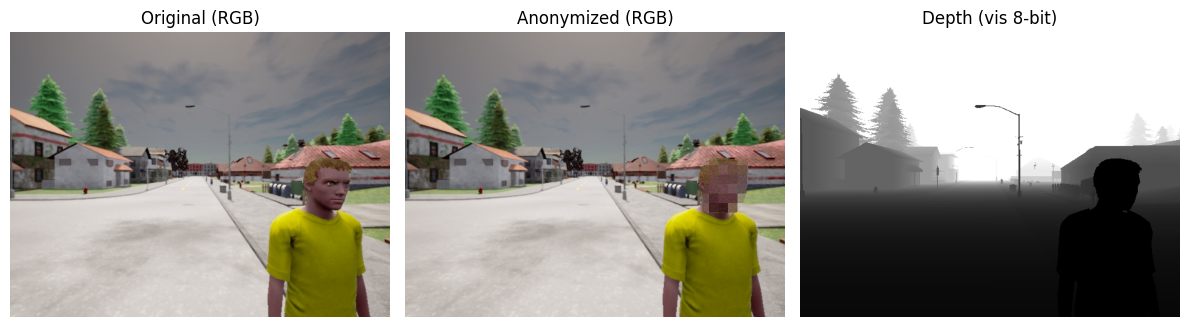

In [8]:

from glob import glob
import os

def newest_n(folder, n=3, pattern="*.jpg"):
    files = sorted(glob(os.path.join(folder, pattern)))
    return files[-n:] if len(files) >= n else files

orig_samples = newest_n(str(orig_dir), n=3, pattern="*.jpg")
anon_samples = [str(anon_dir / Path(p).name) for p in orig_samples]
depth_samples = newest_n(str(depth_dir), n=3, pattern="depth_mm*")

n = min(len(orig_samples), len(anon_samples), len(depth_samples)) // 2
plt.figure(figsize=(12, 4*n))
for i in range(n):
    orig = cv2.cvtColor(cv2.imread(orig_samples[i]), cv2.COLOR_BGR2RGB)
    anon = cv2.cvtColor(cv2.imread(anon_samples[i]), cv2.COLOR_BGR2RGB)
    dep  = cv2.imread(depth_samples[i], cv2.IMREAD_GRAYSCALE)

    # Row i: Original | Anonymized | Depth(8-bit)
    plt.subplot(n, 3, 3*i + 1); plt.imshow(orig); plt.axis("off"); plt.title("Original (RGB)")
    plt.subplot(n, 3, 3*i + 2); plt.imshow(anon); plt.axis("off"); plt.title("Anonymized (RGB)")
    plt.subplot(n, 3, 3*i + 3); plt.imshow(dep, cmap="gray"); plt.axis("off"); plt.title("Depth (vis 8-bit)")
plt.tight_layout()
plt.show()



## 10) Cleanup

Destroy actors and restore the world to async mode.


In [9]:

try:
    for a in actor_list[::-1]:
        if a.is_alive:
            a.destroy()
    print("Destroyed", len(actor_list), "actors.")
finally:
    settings = world.get_settings()
    settings.synchronous_mode = False
    settings.fixed_delta_seconds = None
    world.apply_settings(settings)
    print("World returned to async mode.")


Destroyed 6 actors.
World returned to async mode.
